# Kagle Challenge: House Prices Prediction:

Disclaimer! I know it is horrible practice, but there is no train, test split before predicting the external data. This is because I got higher scores in the competion (predicting the external data) when I trained my models in the whole sample, instead of 80% of it.

Therefore to check how good a model is without commiting data leakage, while also being able to train my model in the whole dataset, I used cross-validation.

However, I'm perfectly aware that good practice would be to split train & test data, cross-validate only on the train one, and check the accuracy of the model on the test one. But as I said, this bad practice is on purpose, and with the objective of using the results of the competion as test data. 

## Imports

In [80]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy import stats
from tempfile import mkdtemp
from shutil import rmtree

from xgboost import XGBRegressor

from sklearn import set_config
set_config(display = 'diagram')

# Sklearn preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.ensemble import AdaBoostRegressor, VotingRegressor, GradientBoostingRegressor, StackingRegressor, RandomForestRegressor
from sklearn.feature_selection import SelectPercentile, mutual_info_regression, VarianceThreshold, SelectFromModel
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor


## Loading Data

In [81]:
# You can use this direct download link if you don't want to create a Kaggle account
data = pd.read_csv('https://wagon-public-datasets.s3.amazonaws.com/houses_train_raw.csv', index_col='Id')
data.head()


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [82]:
X = data.drop(columns=['SalePrice'])
y = data.SalePrice

X.shape, y.shape


((1460, 79), (1460,))

## 1 - Baseline Model

In [83]:
X.dtypes.value_counts()


object     43
int64      33
float64     3
dtype: int64

### 1.1 Initial feature overview: Categorical Variables

In [84]:
feat_categorical_nunique = X.select_dtypes(include='object').nunique()


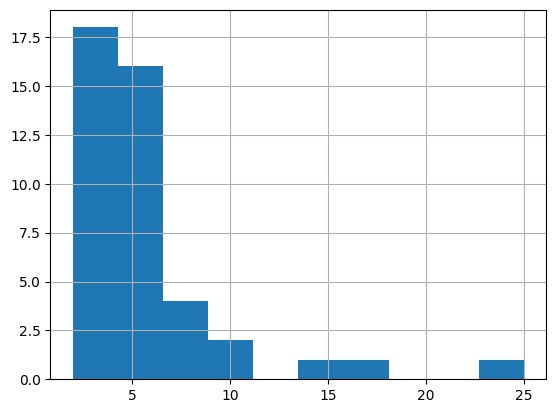

In [85]:
feat_categorical_nunique.hist();


- We will remove all teh features with 7 values or more
- We will One Hot Encode the rest

In [86]:
# categorical features to one-hot-encode
feat_categorical_small = list(feat_categorical_nunique[feat_categorical_nunique < 7].index)


In [87]:
len(feat_categorical_small)


34

### 1.2 Baseline Pipe

In [88]:
preproc_numerical_baseline = make_pipeline(
    SimpleImputer(),
    MinMaxScaler()
)

preproc_categorical_baseline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)

preproc_baseline = make_column_transformer(
    (preproc_numerical_baseline, make_column_selector(dtype_include=["int64", "float64"])),
    (preproc_categorical_baseline, feat_categorical_small),
    remainder="drop"
)

preproc_baseline


ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f09dd729120>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ign...
                                 ['MSZoning', 'Street', 'Alley', 'LotShape',
                                  'LandContour', 'Utilities', 'LotConfig',
                                  'LandSlope', 'BldgType', 'RoofStyle',
                                  'MasVnrType', 'ExterQual', 'ExterCond',
                                  'Foundation', 'BsmtQual', 'BsmtCond',
                                  'BsmtExposure', 'BsmtFinType1',
                                  'BsmtFinType2', 'Heating', 'HeatingQC',
                                  'CentralAir', 'Electrical', 'KitchenQual',
                                  'FireplaceQu', 'GarageType', 'GarageFinish',
                                  'GarageQual', 'GarageCond', 'PavedDrive', ...])])

In [89]:
shape_preproc_baseline = preproc_baseline.fit_transform(X).shape
shape_preproc_baseline


(1460, 183)

In [90]:
pipe_baseline = make_pipeline(preproc_baseline, DecisionTreeRegressor())
pipe_baseline


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f09dd729120>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencod...
                                                   'LotConfig', 'LandSlope',
                                                   'BldgType', 'RoofStyle',
                                                   'MasVnrType', 'ExterQual',
                                                   'ExterCond', 'Foundation',
                                                   'BsmtQual', 'BsmtCond',
                                                   'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', 'KitchenQual',
                                                   'FireplaceQu', 'GarageType',
                                                   'GarageFinish', 'GarageQual',
                                                   'GarageCond', 'PavedDrive', ...])])),
                ('decisiontreeregressor', DecisionTreeRegressor())])

#### Kaggle House Competition is calcultaed with RMSLE

RMSLE formula

$$\text{RMSLE}(y, \hat{y}) = \sqrt{\frac{1}{n_\text{samples}} \sum_{i=0}^{n_\text{samples} - 1} (\log_e (1 + y_i) - \log_e (1 + \hat{y}_i) )^2.}$$

In [91]:
# This is our metric to minimize
rmsle = make_scorer(lambda y_true, y_pred: mean_squared_log_error(y_true, y_pred)**0.5)

# This is our score to maximize
rmsle_neg = make_scorer(lambda y_true, y_pred: -1 * mean_squared_log_error(y_true, y_pred)**0.5)


### 1.3 Baseline Socre

In [92]:
score_baseline = cross_val_score(pipe_baseline, X, y, cv=5, scoring=rmsle).mean()
score_baseline


0.2084739278662469

### 1.4 Baseline Prediction

In [93]:
X_test = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/houses_test_raw.csv")
X_test_ids = X_test['Id'] # Keep ids
X_test = X_test.drop(columns=['Id'])

# Predict y_pred_baseline
pipe_baseline.fit(X,y)
y_pred_baseline = pipe_baseline.predict(X_test)
y_pred_baseline


array([127500., 157900., 192000., ..., 142500.,  93500., 219500.])

In [94]:
results = pd.concat([X_test_ids, pd.Series(y_pred_baseline, name="SalePrice")], axis=1)
results.head(1)


,Id,SalePrice
0,1461,127500.0


In [95]:
# Export to Kaggle format submission in the `data` folder
results.to_csv("data/submission_baseline.csv", header=True, index=False)


# 2. Real Model

## 2.1 Preprocessing 

### 2.1.1 Ordinal Encoding

In [96]:
feat_ordinal_dict = {
    # Considers "missing" as "neutral"
    "BsmtCond": ['missing', 'Po', 'Fa', 'TA', 'Gd'],
    "BsmtExposure": ['missing', 'No', 'Mn', 'Av', 'Gd'],
    "BsmtFinType1": ['missing', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    "BsmtFinType2": ['missing', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    "BsmtQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
    "Electrical": ['missing', 'Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'],
    "ExterCond": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "ExterQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
    "Fence": ['missing', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv'],
    "FireplaceQu": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "Functional": ['missing', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
    "GarageCond": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "GarageFinish": ['missing', 'Unf', 'RFn', 'Fin'],
    "GarageQual": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "HeatingQC": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "KitchenQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
    "LandContour": ['missing', 'Low', 'Bnk', 'HLS', 'Lvl'],
    "LandSlope": ['missing', 'Sev', 'Mod', 'Gtl'],
    "LotShape": ['missing', 'IR3', 'IR2', 'IR1', 'Reg'],
    "PavedDrive": ['missing', 'N', 'P', 'Y'],
    "PoolQC": ['missing', 'Fa', 'Gd', 'Ex']
}

feat_ordinal = sorted(feat_ordinal_dict.keys()) # sort alphabetically
feat_ordinal_values_sorted = [feat_ordinal_dict[i] for i in feat_ordinal]

encoder_ordinal = OrdinalEncoder(
    categories=feat_ordinal_values_sorted,
    dtype= np.int64,
    handle_unknown="use_encoded_value",
    unknown_value=-1 # Considers unknown values as worse than "missing"
)

preproc_ordinal = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    encoder_ordinal,
    MinMaxScaler()
)

preproc_ordinal


Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='missing', strategy='constant')),
                ('ordinalencoder',
                 OrdinalEncoder(categories=[['missing', 'Po', 'Fa', 'TA', 'Gd'],
                                            ['missing', 'No', 'Mn', 'Av', 'Gd'],
                                            ['missing', 'Unf', 'LwQ', 'Rec',
                                             'BLQ', 'ALQ', 'GLQ'],
                                            ['missing', 'Unf', 'LwQ', 'Rec',
                                             'BLQ', 'ALQ', 'GLQ'],
                                            ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
                                            ['missing', 'Mix', 'FuseP...
                                            ['missing', 'Po', 'Fa', 'TA', 'Gd',
                                             'Ex'],
                                            ['missing', 'Po', 'Fa', 'TA', 'Gd',
                                             'Ex'],
                                            ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
                                            ['missing', 'Low', 'Bnk', 'HLS',
                                             'Lvl'],
                                            ['missing', 'Sev', 'Mod', 'Gtl'],
                                            ['missing', 'IR3', 'IR2', 'IR1',
                                             'Reg'],
                                            ['missing', 'N', 'P', 'Y'],
                                            ['missing', 'Fa', 'Gd', 'Ex']],
                                dtype=<class 'numpy.int64'>,
                                handle_unknown='use_encoded_value',
                                unknown_value=-1)),
                ('minmaxscaler', MinMaxScaler())])

In [97]:
# Define numerical feature once-for-all
feat_numerical = sorted(X.select_dtypes(include=["int64", "float64"]).columns)

preproc_numerical = make_pipeline(
    KNNImputer(),
    MinMaxScaler()
)


In [98]:
# Define nominal features to one-hot-encode as the remaining ones (non-numerical, non-ordinal)
feat_nominal = sorted(list(set(X.columns) - set(feat_numerical) - set(feat_ordinal)))

preproc_nominal = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)


In [99]:
preproc = make_column_transformer(
    (preproc_numerical, feat_numerical),
    (preproc_ordinal, feat_ordinal),
    (preproc_nominal, feat_nominal),
    remainder="drop"
)

preproc


ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('knnimputer', KNNImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['1stFlrSF', '2ndFlrSF', '3SsnPorch',
                                  'BedroomAbvGr', 'BsmtFinSF1', 'BsmtFinSF2',
                                  'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF',
                                  'EnclosedPorch', 'Fireplaces', 'FullBath',
                                  'GarageArea', 'GarageCars', 'GarageYrBlt',
                                  'GrLivArea', 'HalfBath', 'Kitc...
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Alley', 'BldgType', 'CentralAir',
                                  'Condition1', 'Condition2', 'Exterior1st',
                                  'Exterior2nd', 'Foundation', 'GarageType',
                                  'Heating', 'HouseStyle', 'LotConfig',
                                  'MSZoning', 'MasVnrType', 'MiscFeature',
                                  'Neighborhood', 'RoofMatl', 'RoofStyle',
                                  'SaleCondition', 'SaleType', 'Street',
                                  'Utilities'])])

In [100]:
pd.DataFrame(preproc.fit_transform(X,y)).head()


,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
0,0.119780,0.413559,0.0,0.375,0.125089,0.0,0.333333,0.0,0.064212,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1,0.212942,0.000000,0.0,0.375,0.173281,0.0,0.000000,0.5,0.121575,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
2,0.134465,0.419370,0.0,0.375,0.086109,0.0,0.333333,0.0,0.185788,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
3,0.143873,0.366102,0.0,0.375,0.038271,0.0,0.333333,0.0,0.231164,0.492754,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
4,0.186095,0.509927,0.0,0.500,0.116052,0.0,0.333333,0.0,0.209760,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0


### 2.1.2 Treat Cyclical Features

In [101]:
# Treat cyclical features
months_in_a_year = 12

X['sin_MoSold'] = np.sin(2 * np.pi * (X.MoSold - 1) / months_in_a_year)
X['cos_MoSold'] = np.cos(2 * np.pi * (X.MoSold - 1) / months_in_a_year)

X.drop(columns=['MoSold'], inplace=True)

X.head()


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,YrSold,SaleType,SaleCondition,sin_MoSold,cos_MoSold
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2008,WD,Normal,0.500000,0.866025
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,2007,WD,Normal,0.866025,-0.500000
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2008,WD,Normal,-0.866025,-0.500000
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2006,WD,Abnorml,0.500000,0.866025
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,2008,WD,Normal,-0.500000,0.866025


### 2.1.3 Target Engineering

- We are asked to minimize the RMSLE. 
- Transform our target to directly predict that

In [102]:
y_log = np.log(y)

# Create your new scorer to minimize
rmse = make_scorer(lambda y_true, y_pred: mean_squared_error(y_true, y_pred)**0.5)

# Create your new scorer to maximize
rmse_neg = make_scorer(lambda y_true, y_pred: -1 * mean_squared_error(y_true, y_pred)**0.5)


## 2.2 Model Pipeline

In [103]:
encoder_ordinal = OrdinalEncoder(
    categories=feat_ordinal_values_sorted,
    dtype= np.int64,
    handle_unknown="use_encoded_value",
    unknown_value=-1 # Considers unknown values as worse than "missing"
)

preproc_ordinal = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    encoder_ordinal,
    MinMaxScaler()
)

preproc_numerical = make_pipeline(
    KNNImputer(),
    MinMaxScaler()
)

preproc_transformer = make_column_transformer(
    (preproc_numerical, make_column_selector(dtype_include=["int64", "float64"])),
    (preproc_ordinal, feat_ordinal),
    (preproc_nominal, feat_nominal),
    remainder="drop"
)

preproc_selector = SelectPercentile(
    mutual_info_regression,
    percentile=50, # keep only xx% of all features (Statistical Feature Selection)
)
preproc = make_pipeline(
    preproc_transformer,
    preproc_selector
)

preproc


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f09dd8d4730>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('o...
                                                   'CentralAir', 'Condition1',
                                                   'Condition2', 'Exterior1st',
                                                   'Exterior2nd', 'Foundation',
                                                   'GarageType', 'Heating',
                                                   'HouseStyle', 'LotConfig',
                                                   'MSZoning', 'MasVnrType',
                                                   'MiscFeature',
                                                   'Neighborhood', 'RoofMatl',
                                                   'RoofStyle', 'SaleCondition',
                                                   'SaleType', 'Street',
                                                   'Utilities'])])),
                ('selectpercentile',
                 SelectPercentile(percentile=50,
                                  score_func=<function mutual_info_regression at 0x7f09e94224d0>))])

In [104]:
# Check shape
preproc_fitted = preproc.fit(X,y)
preproc_fitted_log = preproc.fit(X,y_log)

preproc_fitted_log.transform(X).shape


(1460, 108)

## 2.3 Model Selection

#### 2.3.1 Linear Models (Lasso, Ridge, ElasticNet, SGDRegressor, etc.)

In [105]:
# Ridge with normal target
model = Ridge()

pipe_ridge = make_pipeline(preproc, model)

cross_val_score(pipe_ridge, X, y, cv=5, scoring=rmsle).mean()


0.17052829611305514

In [106]:
# Ridge with log-target (much better)
model = Ridge()

pipe_ridge = make_pipeline(preproc, model)

cross_val_score(pipe_ridge, X, y_log, cv=5, scoring=rmse).mean()


0.13887133948783145

In [107]:
# GridSearch the Ridge regularization
param_grid =  {'ridge__alpha': np.linspace(0.5, 2, num=20)}

search_ridge = GridSearchCV(
    pipe_ridge,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring=rmse_neg
)

search_ridge.fit(X, y_log);

print('\n----------------------------------------\n')
print(f'Best params: {search_ridge.best_params_}')
print(f'Best score: {search_ridge.best_score_}')


Fitting 5 folds for each of 20 candidates, totalling 100 fits


/home/matias/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/matias/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/matias/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/matias/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17

[CV] END ...................................ridge__alpha=0.5; total time=   4.1s
[CV] END ...................................ridge__alpha=0.5; total time=   4.2s
[CV] END ...................................ridge__alpha=0.5; total time=   4.2s
[CV] END ...................................ridge__alpha=0.5; total time=   4.4s
[CV] END ...................................ridge__alpha=0.5; total time=   5.2s
[CV] END ....................ridge__alpha=0.5789473684210527; total time=   5.4s
[CV] END ....................ridge__alpha=0.5789473684210527; total time=   5.4s
[CV] END ....................ridge__alpha=0.5789473684210527; total time=   5.4s
[CV] END ....................ridge__alpha=0.5789473684210527; total time=   3.8s
[CV] END ....................ridge__alpha=0.5789473684210527; total time=   3.7s
[CV] END ....................ridge__alpha=0.6578947368421053; total time=   4.0s
[CV] END ....................ridge__alpha=0.6578947368421053; total time=   4.3s
[CV] END ...................

#### 2.3.2 SVM

In [108]:
model = SVR(kernel='linear')

pipe_svm = make_pipeline(preproc, model)

cross_val_score(pipe_svm, X, y_log, cv=5, scoring=rmse).mean()


0.13732913342914024

In [109]:
model = SVR(kernel='rbf', C = 10)

pipe_svm_rbf = make_pipeline(preproc, model)

cross_val_score(pipe_svm_rbf, X, y_log, cv=5, scoring=rmse).mean()


0.1364476923717272

In [110]:
param_grid =  {
    'svr__C': [0.5, 0.7, 1, 2, 5, 10],
    'svr__epsilon': [0.01, 0.05, 0.1, 0.2, 0.5],
    #'svr__coef0': [0.0, 0.1, 0.5,1],
}

search_svm_rbf = GridSearchCV(
    pipe_svm_rbf,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring=rmse_neg
)

search_svm_rbf.fit(X, y_log);

svm_rbf_best = search_svm_rbf.best_estimator_

print('\n----------------------------------------\n')
print(f'Best params: {search_svm_rbf.best_params_}')
print(f'Best score: {search_svm_rbf.best_score_}')


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[CV] END ......................svr__C=0.5, svr__epsilon=0.01; total time=   3.4s
[CV] END ......................svr__C=0.5, svr__epsilon=0.01; total time=   3.4s
[CV] END ......................svr__C=0.5, svr__epsilon=0.01; total time=   3.5s
[CV] END ......................svr__C=0.5, svr__epsilon=0.01; total time=   3.5s
[CV] END ......................svr__C=0.5, svr__epsilon=0.05; total time=   3.1s
[CV] END ......................svr__C=0.5, svr__epsilon=0.01; total time=   3.2s
[CV] END ......................svr__C=0.5, svr__epsilon=0.05; total time=   3.2s
[CV] END ......................svr__C=0.5, svr__epsilon=0.05; total time=   3.3s
[CV] END ......................svr__C=0.5, svr__epsilon=0.05; total time=   3.1s
[CV] END ......................svr__C=0.5, svr__epsilon=0.05; total time=   3.0s
[CV] END .......................svr__C=0.5, svr__epsilon=0.1; total time=   3.0s
[CV] END .......................svr__C=0.5, svr__epsilon=0.1; total time=   3.2s
[CV] END ...................

#### 2.3.4 Trees

In [111]:
model = DecisionTreeRegressor(max_depth=50, min_samples_leaf=20)

pipe = make_pipeline(preproc, model)

score = cross_val_score(pipe, X, y_log, cv=5, scoring=rmse)

print(score.std())
print(score.mean())


0.010123412279882534
0.1888197267087174


- Random Forest

In [112]:
model = RandomForestRegressor(max_depth=50,min_samples_leaf=20)

pipe = make_pipeline(preproc, model)

score = cross_val_score(pipe, X, y_log, cv=5, scoring=rmse)

print(score.std())
print(score.mean())


0.007996226113230616
0.16209686930749836


- Boosted Trees

In [113]:
model = AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=None))

pipe = make_pipeline(preproc, model)

score = cross_val_score(pipe, X, y_log, cv=5, scoring=rmse)

print(score.std())
print(score.mean())


0.009525938684766061
0.14392216520883344


In [114]:
model = GradientBoostingRegressor(n_estimators=100, verbose=0)

pipe_gb = make_pipeline(preproc, model)

score = cross_val_score(pipe_gb, X, y_log, cv=5, scoring=rmse)

print(score.std())
print(score.mean())


0.00978000110129788
0.12707261892755092


In [115]:
grid = {
    'gradientboostingregressor__n_estimators': stats.randint(50,300),
    # 'gradientboostingregressor__learning_rate': stats.uniform(0.05, 0.3),
    # 'gradientboostingregressor__loss': ['lad', 'huber', 'quantile'],
    # 'gradientboostingregressor__max_depth': stats.randint(3, 5),
    # 'gradientboostingregressor__min_samples_split': stats.randint(2, 10),
    # 'gradientboostingregressor__subsample': [0.95, 1], # 1 default
    'gradientboostingregressor__max_features': stats.randint(0.9, len(X.columns)) # default None, i.e = n_features
}

search_gb = RandomizedSearchCV(pipe_gb, grid, scoring=rmse_neg, n_iter=8, cv=5, n_jobs=1, verbose=2)

# Fit data to GridSearch
search_gb.fit(X, y_log);

print('\n----------------------------------------\n')
print(f'Best params: {search_gb.best_params_}')
print(f'Best score: {search_gb.best_score_}')


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[CV] END gradientboostingregressor__max_features=58, gradientboostingregressor__n_estimators=109; total time=   2.4s
[CV] END gradientboostingregressor__max_features=58, gradientboostingregressor__n_estimators=109; total time=   2.3s
[CV] END gradientboostingregressor__max_features=58, gradientboostingregressor__n_estimators=109; total time=   2.3s
[CV] END gradientboostingregressor__max_features=58, gradientboostingregressor__n_estimators=109; total time=   2.6s
[CV] END gradientboostingregressor__max_features=58, gradientboostingregressor__n_estimators=109; total time=   2.9s
[CV] END gradientboostingregressor__max_features=25, gradientboostingregressor__n_estimators=61; total time=   2.0s
[CV] END gradientboostingregressor__max_features=25, gradientboostingregressor__n_estimators=61; total time=   2.0s
[CV] END gradientboostingregressor__max_features=25, gradientboostingregressor__n_estimators=61; total time=   2.0s
[CV] END gradientboostingregressor__max_features=25, gradientboosti

## 2.4 Complex Models

#### 2.4.1 Stacking

In [116]:
gboost = GradientBoostingRegressor(n_estimators=100)
ridge = Ridge()
svm = SVR(C=1, epsilon=0.05)
adaboost = AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=None))


model = VotingRegressor(
    estimators = [("gboost", gboost), ("adaboost", adaboost), ("ridge", ridge), ("svm_rbf", svm)],
    weights = [1, 1, 1, 1], # to equally weight the models
    n_jobs=-1
)

pipe_ensemble = make_pipeline(preproc, model)

score = cross_val_score(pipe_ensemble, X, y_log, cv=5, scoring=rmse, n_jobs=-1)

print(score.std())
print(score.mean())


0.010942163864350598
0.12047943414591744


In [117]:
gboost = GradientBoostingRegressor(n_estimators=100)
ridge = Ridge()
svm = SVR(C=1, epsilon=0.05)
adaboost = AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=None))

model = StackingRegressor(
    estimators=[("gboost", gboost), ("adaboost", adaboost), ("ridge", ridge), ("svm_rbf", svm)],
    final_estimator=LinearRegression(),
    cv=5,
    n_jobs=-1
)

pipe_stacking = make_pipeline(preproc, model)

score = cross_val_score(pipe_stacking, X, y_log, cv=5, scoring=rmse, n_jobs=-1)

print(score.std())
print(score.mean())


0.011906941855770101
0.12089036900704671


#### 2.4.2 XGBoost

In [118]:
X_train, X_eval, y_train_log, y_eval_log = train_test_split(X, y_log, random_state=42)


In [119]:
# Instantiate model
model_xgb = XGBRegressor(max_depth=10, n_estimators=300, learning_rate=0.1)


In [120]:
pipe_xgb = make_pipeline(preproc, model_xgb)

cross_val_score(pipe_xgb, X, y_log, cv=5, scoring=rmse, n_jobs=-1).mean()


0.13332710414333038

# 3 SUBMISSION

In [121]:
X_test = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/houses_test_raw.csv")

X_test_ids = X_test['Id'] # Keep ids
X_test = X_test.drop(columns=['Id'])


In [122]:
# Adding columns to X_test according to what we did to X
X_test['sin_MoSold'] = np.sin(2 * np.pi * (X_test.MoSold - 1) / months_in_a_year)
X_test['cos_MoSold'] = np.cos(2 * np.pi * (X_test.MoSold - 1) / months_in_a_year)

X_test.drop(columns=['MoSold'], inplace=True)


In [123]:
pipe_stacking.fit(X, y_log)

predictions_log = pipe_stacking.predict(X_test)
predictions = np.exp(predictions_log)


In [124]:
results = pd.concat([X_test_ids, pd.Series(predictions, name="SalePrice")], axis=1)
results


,Id,SalePrice
0,1461,118425.819148
1,1462,154037.904599
2,1463,178383.128305
3,1464,187367.699549
4,1465,193111.771700
...,...,...
1454,2915,78302.463723
1455,2916,80029.084186
1456,2917,166301.385174
1457,2918,112046.872199


In [125]:
results.to_csv("data/submission_final.csv", header=True, index=False)
